In [1]:
import numpy as np
import  random  
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [2]:
# Load the experiment data
mem = Memory("./mycache")

@mem.cache
def get_data(path,feature):
    data = load_svmlight_file(path,feature)    
    return data

In [3]:
def predict(W , X, y ):
    """
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - x: A numpy array of shape (N, D) containing a minibatch of training data.
    - y: A numpy array of shape (N,) containing training labels; ytrain[i] = c means that xtrain[i] has label c, where 0 <= c <C.
   
    Returns a tuple of:
    - prediction of y
    - accuracy of the model
    """
    # the class scores for all examples
    score = np.dot(X,W)
    # find the index with max score in each column (the predicted class)
    y_pred= np.argmax(score, axis = 1)
    # and calculate accuracy (fraction of predictions that are correct)
    cmp=(y_pred == y)
    accuracy=len(cmp[cmp==True])/len(cmp)
    
    return y_pred,accuracy 

Loss Function:
$$ L= \frac{1}{N}\sum_{i}\sum_{j\ne y_i}[max(0,f(x_i;W)_j-f(x_i;W)_{y_i}+\Delta]+\lambda \sum_k\sum_lW^2_{k,l}$$
Gradient Matrix:
$$ \frac{\partial L_i}{\partial w_{y_i}}=-(\sum_{y \ne y_i}1(w^T_jx_i-w^T_{y_i}x_i+\Delta>0))x_i \quad \quad (j=y_i)$$
$$ \frac{\partial L_i}{\partial w_j}=1(w^T_jx_i-w^T_{y_i}x_i+\Delta>0))x_i \quad \quad \quad \quad (j\ne y_i)$$
where l(x) is an indicator function：
$$l(x==T)=1$$
$$l(x==F)=0$$

In [4]:
def svm(W, xtrain, ytrain, xtest, ytest, reg):
  """
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - xtrain: A numpy array of shape (num_train, D) containing a minibatch of training data.
  - ytrain: A numpy array of shape (num_train,) containing training labels; ytrain[i] = c means that xtrain[i] has label c, where 0 <= c <C.
  - xtest: A numpy array of shape (num_test, D) containing a minibatch of test data.
  - ytest: A numpy array of shape (num_test,) containing test labels
  - reg: (float) regularization strength
  
  Returns a tuple of:
  - train_loss as single float
  - test_loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero  
  num_classes = W.shape[1]

  #train 
  train_loss = 0
  scores_train = xtrain.dot(W)  # num_train by C
  num_train = xtrain.shape[0]
  scores_train_correct = scores_train[np.arange(num_train), ytrain] # 1 by num_train
  scores_train_correct = np.reshape(scores_train_correct, (num_train, 1)) # num_train by 1
  margins_train = scores_train - scores_train_correct + 1.0 # num_train by C
  margins_train[np.arange(num_train), ytrain] = 0.0 
  margins_train[margins_train <= 0] = 0.0
  train_loss += np.sum(margins_train) / num_train
  train_loss += 0.5 * reg * np.sum(W * W) 
  margins_train[margins_train > 0] = 1.0                       
  row_sum = np.sum(margins_train, axis=1)                  # 1 by num_train
  margins_train[np.arange(num_train), ytrain] = -row_sum        

  gradNum =20 #number of choosed partial samples.
  ind=random.sample(range(0,num_train),gradNum)  
  xtrain_batch=xtrain[ind,:]
  margins_train_batch=margins_train[ind,:]
  dW += np.dot(xtrain_batch.T, margins_train_batch)/gradNum + reg * W     # D by C
  #test
  test_loss = 0
  scores_test = xtest.dot(W)  # num_test by C
  num_test = xtest.shape[0]
  scores_test_correct = scores_test[np.arange(num_test), ytest] # 1 by N
  scores_test_correct = np.reshape(scores_test_correct, (num_test, 1)) # N by 1
  margins_test = scores_test - scores_test_correct + 1.0 # N by C
  margins_test[np.arange(num_test), ytest] = 0.0 
  margins_test[margins_test <= 0] = 0.0
  test_loss += np.sum(margins_test) / num_test
  test_loss += 0.5 * reg * np.sum(W * W)

  return train_loss, test_loss, dW


In [5]:
# Data preparation  
data = get_data(path="D:\研一\课件\深度学习\libsvm-3.22\A9a_trainingData",feature=123)

# Data preprocessing
x_train=data[0].toarray()
x_train=np.column_stack((x_train,np.ones([x_train.shape[0],1]))) #add bias 
y_train=data[1]
C=len(list(set(y_train))) # total number of labels
y_train=y_train.astype(np.int)  # float->int
y_train[y_train== -1]=0
N,D  =x_train.shape


# Data preparation  
data = get_data(path="D:\研一\课件\深度学习\libsvm-3.22\A9a_testData",feature=123)

# Data preprocessing
x_test=data[0].toarray()
x_test=np.column_stack((x_test,np.ones([x_test.shape[0],1]))) #add bias 
y_test=data[1]
y_test=y_test.astype(np.int)  # float->int
y_test[y_test== -1]=0


In [6]:
# Initialize parameter   
maxIterations=200
eta = 1e-3 # learning rate

NAG :
$$d_{t}=\gamma * d_{t-1} + g_{t-1} + \gamma * (g_{t-1}-g_{t-2}) $$

$$ \Delta W= -\eta*d_t$$

$$ W_t=W_{t-1}+ \Delta W$$

In [7]:
# NAG
# Initialize parameter   
W = np.zeros((D, C)) # weights
pre_d = np.zeros_like(W)
pre_grad = np.zeros_like(W)
gamma =0.9 # momentum factor 
L_NAG =[]; # validation loss
for t in range(maxIterations):
    
    # Compute loss
    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    
    # Save the values
    L_NAG.append ( test_loss)
    
    # Update weights using Nesterov Accelerated Gradient(NAG)
    d  = gamma * pre_d  + grad + gamma * (grad - pre_grad)
    dW = -eta * d
    W += dW 
    pre_d = d
    pre_grad = grad
    
L_NAG=np.array(L_NAG)
#Predicted Result
y_pred_NAG_train,training_accuracy_NAG = predict(W , x_train, y_train )
y_pred_NAG_test,test_accuracy_NAG = predict(W , x_test, y_test )


RMSProp :
$$n_{t}=\gamma * n_{t-1} + (1- \gamma ) * g^2_t $$

$$ \Delta W= \frac {-\eta}{\sqrt{n_t+\epsilon}}*g_t$$

$$ W=W+\Delta W$$

In [8]:
# RMSProp 
# Initialize parameter   
W = np.zeros((D, C)) # weights
n = np.zeros_like(W)
gamma =0.9 # decay factor 
epsilon = 0.001 # in case of the denominator equalling to 0
L_RMSProp =[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    
    # Save the values
    L_RMSProp.append ( test_loss)
    
    # Update weights using RMSProp

    n = gamma * n + (1-gamma) * np.power(grad,2)
    dW = -eta /np.sqrt(n + epsilon ) * grad
    W += dW 
    
L_RMSProp=np.array(L_RMSProp)
#Predicted Result
y_pred_RMSProp_train,training_accuracy_RMSProp = predict(W , x_train, y_train )
y_pred_RMSProp_test,test_accuracy_RMSProp = predict(W , x_test, y_test )

AdaDelta :
$$E[g^2]_t=\gamma  E[g^2]_{t-1} + (1-\gamma)g^2_t$$

$$\Delta W_t=-\frac{\sqrt{E[\Delta W^2]_{t-1}+\epsilon}}{\sqrt{E[g^2]_t+\epsilon}}g_t$$

$$W=W+\Delta W$$

$$E[\Delta W^2_t]_t=\gamma  E[\Delta W^2_t]_{t-1} +(1-\gamma)\Delta W^2_t$$

In [9]:
# AdaDelta 
# Initialize parameter   
W = np.zeros((D, C)) # weights
E_g2 = np.zeros_like(W)
E_dW2 = np.zeros_like(W)
gamma =0.8 # decay factor 
epsilon = 1e-6# in case of the denominator equalling to 0
L_AdaDelta =[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    
    # Save the values
    L_AdaDelta.append ( test_loss)
    
    # Update weights using AdaDelta
    E_g2 = gamma * E_g2 + (1-gamma) * np.power(grad,2)
    dW = - np.sqrt(E_dW2+epsilon) / np.sqrt(E_g2+epsilon) * grad    
    W += dW 
    E_dW2 = gamma * E_dW2 + (1-gamma) * np.power(dW , 2)
    
L_AdaDelta=np.array(L_AdaDelta)
#Predicted Result
y_pred_AdaDelta_train,training_accuracy_AdaDelta = predict(W , x_train, y_train )
y_pred_AdaDelta_test,test_accuracy_AdaDelta= predict(W , x_test, y_test )

Adam:
$$m_t=\mu * m_{t-1} + (1-\mu) * g_t$$

$$n_t=v*n_{t-1}+(1-v)*g^2_t$$

$$\hat{m_t}=\frac{m_t}{1-\mu^t+\epsilon}$$

$$\hat{n_t}=\frac{n_t}{1-v^t+\epsilon}$$

$$\Delta W=-\frac{\hat{m_t}}{\sqrt{\hat{n_t}}+\epsilon}*\eta$$

In [10]:
# Adam
# Initialize parameter   
W = np.zeros((D, C)) # weights
n = np.zeros_like(W)
m = np.zeros_like(W)
mu = 0.9
v = 0.9
epsilon = 1e-3 # in case of the denominator equalling to 0
L_adam=[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    
    # Save the values
    L_adam.append ( test_loss)
    
    # Update weights using RMSProp
    m = mu * m + (1-mu) * grad
    n = v  * n + (1-v) * np.power(grad,2)
    m_hat = m / (1-np.power(mu,t)+epsilon) 
    n_hat = n / (1-np.power(v,t)+epsilon)
    W -= m_hat * eta /(np.sqrt(n_hat) + epsilon)
    
L_adam=np.array(L_adam)
#Predicted Result
y_pred_Adam_train,training_accuracy_Adam = predict(W , x_train, y_train )
y_pred_Adam_test,test_accuracy_Adam = predict(W , x_test, y_test )

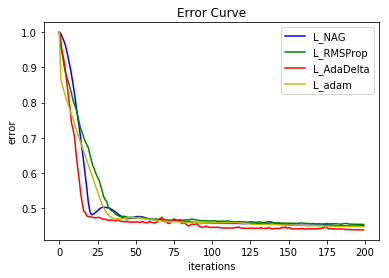

In [11]:
# Plot
plt.plot(L_NAG,'b',label='L_NAG')
plt.plot(L_RMSProp,'g',label='L_RMSProp')
plt.plot(L_AdaDelta,'r',label='L_AdaDelta')
plt.plot(L_adam,'y',label='L_adam')
plt.title('Error Curve') # give plot a title
plt.xlabel('iterations')# make axis labels
plt.ylabel('error')
plt.legend()
plt.show()

In [12]:
print('\n---------Assessment Result---------\ntraining accuracy_NAG=',training_accuracy_NAG,
      '\ntraining accuracy_RMSProp=',training_accuracy_RMSProp,
      '\ntraining accuracy_AdaDelta=',training_accuracy_AdaDelta,
      '\ntraining accuracy_Adam=',training_accuracy_Adam)

print('\n---------Predicted Results---------\ntest accuracy_NAG=',test_accuracy_NAG,
      '\ntest accuracy_RMSProp=',test_accuracy_RMSProp,
      '\ntest accuracy_AdaDelta=',test_accuracy_AdaDelta,
      '\ntest accuracy_Adam=',test_accuracy_Adam)


---------Assessment Result---------
training accuracy_NAG= 0.7605724639906637 
training accuracy_RMSProp= 0.7591904425539756 
training accuracy_AdaDelta= 0.7942323638708885 
training accuracy_Adam= 0.7638893154387151

---------Predicted Results---------
test accuracy_NAG= 0.7646950433020084 
test accuracy_RMSProp= 0.7637737239727289 
test accuracy_AdaDelta= 0.7976782752902156 
test accuracy_Adam= 0.7679503715987961
